In [1]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pydub import AudioSegment
from tensorflow import keras
from scipy.io import wavfile
from threading import Thread
from queue import Queue
import tensorflow as tf
from time import sleep
from time import time
import numpy as np
import librosa.display
import warnings
import librosa
import IPython
import pyaudio
import random
import glob
import sys
import io
import os
from scipy.io.wavfile import write
from pydub.playback import play

activation_sound = AudioSegment.from_wav('Activation_Notification_Sound/confident_cutted.wav')

%matplotlib inline

warnings.filterwarnings('ignore')
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [2]:
Tx = 862 # The number of time steps input to the model from the spectrogram
Ty = int((Tx - 15)/4 + 1) # The number of time steps in the output of our model
n_freq = 128 # Number of frequencies input to the model at each time step of the spectrogram

In [3]:
# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

def graph_mel_spectogram(wav_file):
    y, sr = librosa.load(wav_file, sr=44100)
    print(y.shape, sr)
    # trim silent edges
    activation, _ = librosa.effects.trim(y)
    n_fft = 2048
    hop_length = 512
    n_mels = 128
    S = librosa.feature.melspectrogram(activation, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    #plt.colorbar(format='%+2.0f dB');
    return S_DB

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

In [4]:
def detect_triggerword_prob_true(filename, Y, idx):
    plt.subplot(3, 1, 1)

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x = x[:, :5511]
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(3, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    
    plt.subplot(3, 1, 3)
    plt.plot(Y[idx])
    
    plt.show()
    return predictions

def detect_triggerword_mel_prob_true(filename, Y, idx):
    plt.subplot(3, 1, 1)

    x = graph_mel_spectogram(filename)
    print(x.shape)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x = x[:, :Tx]
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(3, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    
    plt.subplot(3, 1, 3)
    plt.plot(Y[idx])
    plt.ylabel('probability')
    
    #plt.savefig(f"{idx}.png", dpi=400, format="png")
    plt.show()
    return predictions

In [5]:
MAIN_IDX = 3
#############
Y = np.load(f'Y_train{MAIN_IDX}_mel.npy')

path = "model-rnn-comrade-44100-mel.v4.h5"
model = keras.models.load_model(path)

(441000,) 44100


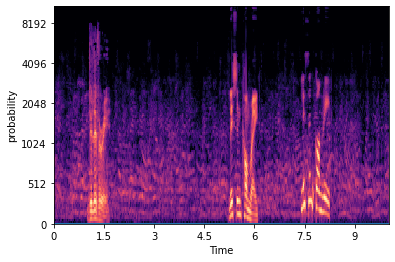

In [6]:
x = graph_mel_spectogram("TRAIN_MEL3/train3_mel899.wav")
x = x[:, :Tx]
x  = x.swapaxes(0,1)
x = np.expand_dims(x, axis=0)
predictions = model.predict(x)
plt.plot(predictions[0,:,0])
plt.ylabel('probability')
#plt.savefig(f"899_prediction_only.png", dpi=800, format="png", transparent=False)

(441000,) 44100
(128, 862)


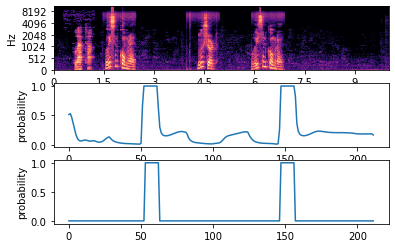

(441000,) 44100
(128, 861)


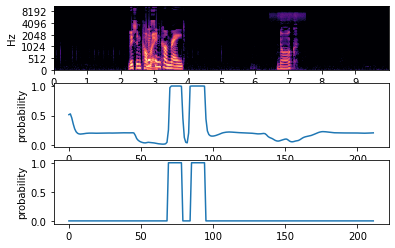

(441000,) 44100
(128, 862)


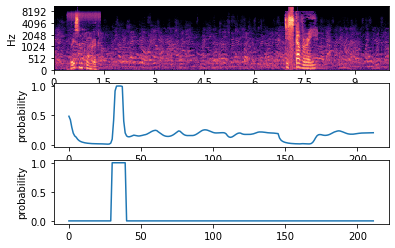

(441000,) 44100
(128, 862)


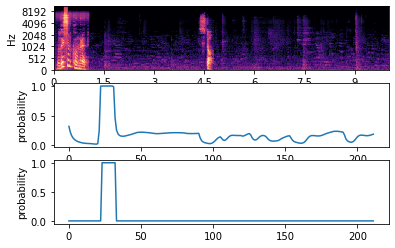

(441000,) 44100
(128, 786)


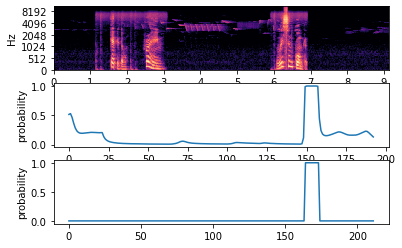

(441000,) 44100
(128, 862)


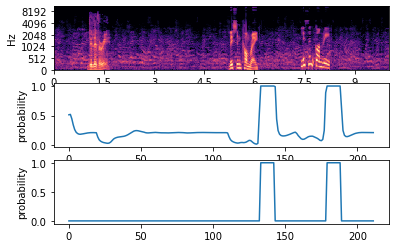

(441000,) 44100
(128, 862)


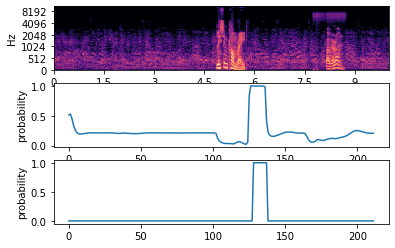

(441000,) 44100
(128, 861)


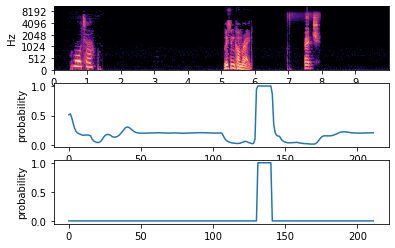

(441000,) 44100
(128, 862)


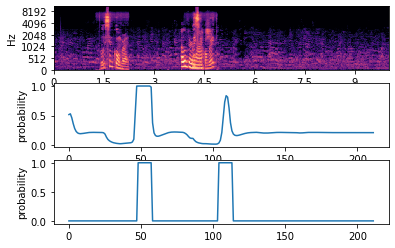

In [7]:
ls = [123, 145, 169, 240, 385, 899, 923, 1035, 2934]
for idx in ls:
    filename = f"TRAIN_MEL{MAIN_IDX}/train{MAIN_IDX}_mel{idx}.wav"
    prediction = detect_triggerword_mel_prob_true(filename, Y, idx)
    #IPython.display.Audio(filename)

In [7]:
prediction_reshaped = prediction.reshape(-1)
prediction.shape, "=(prediction.reshape(-1))=>" ,prediction_reshaped.shape

((1, 212, 1), '=(prediction.reshape(-1))=>', (212,))

# Audio recognition from stream

In [9]:
# Unused in current version
def get_spectrogram(data):
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, _, _ = mlab.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, _, _ = mlab.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

def get_mel_spectogram(data):
    #y, sr = librosa.load(wav_file)
    sr = fs
    activation = data
    #activation, _ = librosa.effects.trim(y)
    n_fft = 2048
    hop_length = 512
    n_mels = 128
    S = librosa.feature.melspectrogram(activation, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
    return S_DB

def detect_triggerword_spectrum(x):
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    return predictions.reshape(-1)

def has_new_triggerword(predictions, chunk_duration, feed_duration, threshold):
    predictions = predictions > threshold
    chunk_predictions_samples = int(len(predictions) * chunk_duration / feed_duration)
    chunk_predictions = predictions[-chunk_predictions_samples:]
    level = chunk_predictions[0]
    for pred in chunk_predictions:
        if pred > level:
            return True
        else:
            level = pred
    return False

In [7]:
def callback(in_data, frame_count, time_info, status):
    global run, timeout, data, silence_threshold    
    if time() > timeout:
        run = False        
    data0 = np.frombuffer(in_data, dtype=np.float32)
    sys.stdout.write('.')
    data = np.append(data, data0)    
    if len(data) > feed_samples:
        data = data[-feed_samples:]
        q.put(data)
    return (in_data, pyaudio.paContinue)

def get_audio_input_stream(callback):
    stream = pyaudio.PyAudio().open(
        format=pyaudio.paFloat32,
        #format=pyaudio.paInt16,
        channels=1,
        rate=fs,
        input=True,
        frames_per_buffer=chunk_samples,
        stream_callback=callback
    )
    return stream

......A..A..A..A....

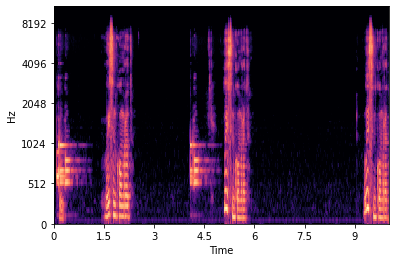

In [61]:
chunk_duration = 2 # second
# Next line accepts only 48K to prevent bug: https://bbs.archlinux.org/viewtopic.php?id=244322
# But it's somehow works again with 44100 Hz
fs = 44100 # sampling rate
chunk_samples = int(fs * chunk_duration) # Each read length in number of samples.

feed_duration = 10 # seconds
feed_samples = int(fs * feed_duration)

# Queue to communiate between the audio callback and main thread
q = Queue()
run = True

# Run the demo for a timeout seconds
timeout = time() + 0.5 * 60  # 1 minutes from now

# Data buffer for the input wavform
data = np.zeros(chunk_samples, dtype=np.float32)

####################
#!!!!!!!!!!!!!!!!!!#
####################
stream = get_audio_input_stream(callback)
stream.start_stream()

try:
    while run:
        data = q.get()
        #data = np.frombuffer(stream.read(chunk_duration * fs), dtype='int16') 
        #if not np.isfinite(data).all():
        #    data = np.nan_to_num(data)
        spectrum = get_mel_spectogram(data)
        preds = detect_triggerword_spectrum(spectrum)
        new_trigger = has_new_triggerword(preds, chunk_duration, feed_duration, threshold=0.3)
        if new_trigger:
            sys.stdout.write('A')
            play(activation_sound)
except (KeyboardInterrupt, SystemExit):
    stream.stop_stream()
    stream.close()
    timeout = time()
    run = False
        
stream.stop_stream()
stream.close()

write("10_last_seconds.wav", fs, data)
####################
#!!!!!!!!!!!!!!!!!!#
####################

(441000,) 44100
(128, 862)


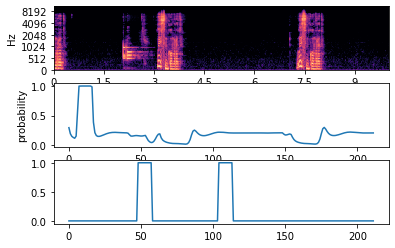

In [62]:
filename = f"10_last_seconds.wav"
prediction = detect_triggerword_mel_prob_true(filename, Y, idx)

In [48]:
X_dev, Y_dev = np.load(f'X_dev_mel.npy'), np.load(f'Y_dev_mel.npy')

loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

16/16 [==============================] - 0s 16ms/step - loss: 0.2704 - accuracy: 0.9711
Dev set accuracy =  0.9710992574691772


In [68]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(f"{path.split('/')[-1][:-3]}.tflite", "wb").write(tflite_model)

2556212